In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BTC2019-2024.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 22s 417ms/step - loss: 0.0433
Epoch 2/100
22/22 [==============================] - 4s 176ms/step - loss: 0.0051
Epoch 3/100
22/22 [==============================] - 5s 208ms/step - loss: 0.0033
Epoch 4/100
22/22 [==============================] - 4s 164ms/step - loss: 0.0030
Epoch 5/100
22/22 [==============================] - 4s 165ms/step - loss: 0.0030
Epoch 6/100
22/22 [==============================] - 3s 157ms/step - loss: 0.0027
Epoch 7/100
22/22 [==============================] - 5s 236ms/step - loss: 0.0025
Epoch 8/100
22/22 [==============================] - 3s 155ms/step - loss: 0.0025
Epoch 9/100
22/22 [==============================] - 3s 154ms/step - loss: 0.0021
Epoch 10/100
22/22 [==============================] - 5s 208ms/step - loss: 0.0022
Epoch 11/100
22/22 [==============================] - 4s 175ms/step - loss: 0.0019
Epoch 12/100
22/22 [==============================] - 4s 175ms/step - loss: 0.0019
Epoch 13/100

In [10]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 35ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 34686.36977856788


RMSE đo lường độ lệch chuẩn của các dự đoán so với giá trị thực tế. RMSE càng nhỏ thì mô hình càng chính xác. Với RMSE = 34686.37, mô hình có mức sai số rất cao, cho thấy sự khác biệt lớn giữa giá trị dự đoán và giá trị thực tế. Đây là một dấu hiệu cho thấy mô hình dự đoán đang gặp vấn đề nghiêm trọng trong việc khớp dữ liệu.

In [13]:
# Tính MAPE
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

Testing MAPE: 7601907.342036105


MAPE đo lường phần trăm sai số tuyệt đối giữa giá trị dự đoán và giá trị thực tế. MAPE càng nhỏ thì mô hình càng chính xác. Với MAPE = 7601907.34%, giá trị này cực kỳ cao, cho thấy mô hình dự đoán không tốt.

In [14]:
# Tính MSE
test_mse = np.mean((y_pred - ytest) ** 2)
print('Testing MSE:', test_mse)

Testing MSE: 1203144248.4155474


MSE đo lường sai số trung bình của mô hình bằng cách tính trung bình của các bình phương sai số. MSE càng nhỏ thì mô hình càng chính xác. Với MSE = 1203144248.42, mô hình có mức sai số rất cao, cho thấy mô hình chưa đủ tốt để dự đoán chính xác.

In [15]:
# 13. Dự báo 30 ngày tiếp theo
from numpy import array

x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1



0 day input [0.52585642 0.52309932 0.52179016 0.51313626 0.49801659 0.53473678
 0.50768866 0.51461464 0.51444255 0.52699392 0.52841089 0.50234495
 0.52771162 0.52547483 0.53222443 0.53342358 0.5284448  0.52491918
 0.53396104 0.53439057 0.53210634 0.54740294 0.55974647 0.56761507
 0.5989872  0.63190847 0.62667061 0.61955864 0.63325559 0.62634993
 0.62719179 0.58744794 0.59068263 0.61325944 0.61534752 0.59819824
 0.6030624  0.5893417  0.60907165 0.60353901 0.62519432 0.62859376
 0.63061162 0.62656243 0.61522441 0.62458137 0.60745522 0.62191254
 0.6091393  0.60085702 0.6017582  0.60345532 0.63326704 0.64565844
 0.61259231 0.63346435 0.63319431 0.63047516 0.62975268 0.67720027
 0.66417982 0.67182882 0.6677666  0.61267056 0.61250152 0.59610612
 0.60732305 0.61740022 0.61093848 0.5877336  0.59331852 0.59405796
 0.59218035 0.56023287 0.56553311 0.56916171 0.56691635 0.596429
 0.6011807  0.59985697 0.6194894  0.61422907 0.60843011 0.61615938
 0.61788472 0.61485034 0.60844542 0.60962222 0.61629

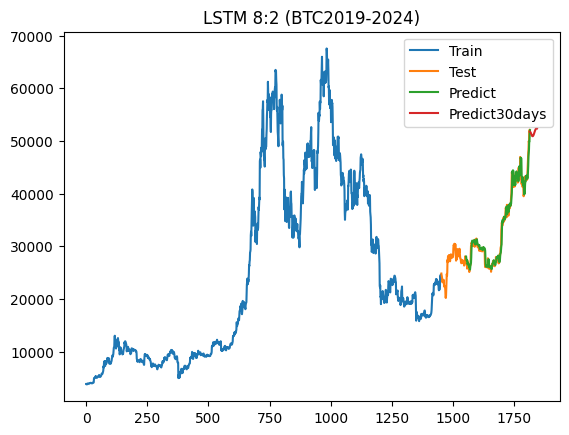

In [16]:
# 14.Vẽ hình
plt.title('LSTM 8:2 (BTC2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [17]:
from numpy import array

y_input = test_data[60:].reshape(1, -1)
y_input.shape

temp_input = list(y_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 60):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        y_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, y_input))
        y_input = y_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(y_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        y_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(y_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.52585642 0.52309932 0.52179016 0.51313626 0.49801659 0.53473678
 0.50768866 0.51461464 0.51444255 0.52699392 0.52841089 0.50234495
 0.52771162 0.52547483 0.53222443 0.53342358 0.5284448  0.52491918
 0.53396104 0.53439057 0.53210634 0.54740294 0.55974647 0.56761507
 0.5989872  0.63190847 0.62667061 0.61955864 0.63325559 0.62634993
 0.62719179 0.58744794 0.59068263 0.61325944 0.61534752 0.59819824
 0.6030624  0.5893417  0.60907165 0.60353901 0.62519432 0.62859376
 0.63061162 0.62656243 0.61522441 0.62458137 0.60745522 0.62191254
 0.6091393  0.60085702 0.6017582  0.60345532 0.63326704 0.64565844
 0.61259231 0.63346435 0.63319431 0.63047516 0.62975268 0.67720027
 0.66417982 0.67182882 0.6677666  0.61267056 0.61250152 0.59610612
 0.60732305 0.61740022 0.61093848 0.5877336  0.59331852 0.59405796
 0.59218035 0.56023287 0.56553311 0.56916171 0.56691635 0.596429
 0.6011807  0.59985697 0.6194894  0.61422907 0.60843011 0.61615938
 0.61788472 0.61485034 0.60844542 0.60962222 0.61629

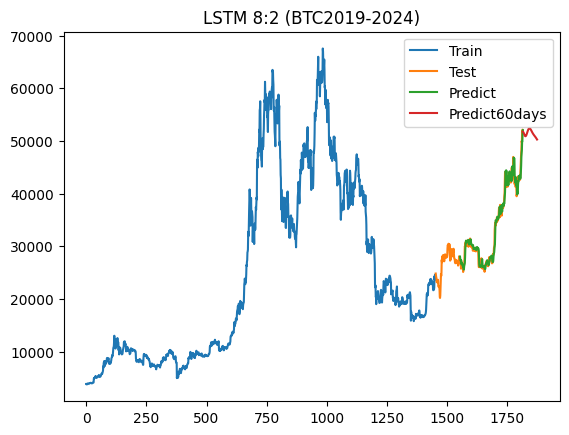

In [18]:
# 14.Vẽ hình
plt.title('LSTM 8:2 (BTC2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [19]:
from numpy import array

z_input = test_data[60:].reshape(1, -1)
z_input.shape

temp_input = list(z_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        z_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, z_input))
        z_input = z_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(z_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        z_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(z_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.52585642 0.52309932 0.52179016 0.51313626 0.49801659 0.53473678
 0.50768866 0.51461464 0.51444255 0.52699392 0.52841089 0.50234495
 0.52771162 0.52547483 0.53222443 0.53342358 0.5284448  0.52491918
 0.53396104 0.53439057 0.53210634 0.54740294 0.55974647 0.56761507
 0.5989872  0.63190847 0.62667061 0.61955864 0.63325559 0.62634993
 0.62719179 0.58744794 0.59068263 0.61325944 0.61534752 0.59819824
 0.6030624  0.5893417  0.60907165 0.60353901 0.62519432 0.62859376
 0.63061162 0.62656243 0.61522441 0.62458137 0.60745522 0.62191254
 0.6091393  0.60085702 0.6017582  0.60345532 0.63326704 0.64565844
 0.61259231 0.63346435 0.63319431 0.63047516 0.62975268 0.67720027
 0.66417982 0.67182882 0.6677666  0.61267056 0.61250152 0.59610612
 0.60732305 0.61740022 0.61093848 0.5877336  0.59331852 0.59405796
 0.59218035 0.56023287 0.56553311 0.56916171 0.56691635 0.596429
 0.6011807  0.59985697 0.6194894  0.61422907 0.60843011 0.61615938
 0.61788472 0.61485034 0.60844542 0.60962222 0.61629

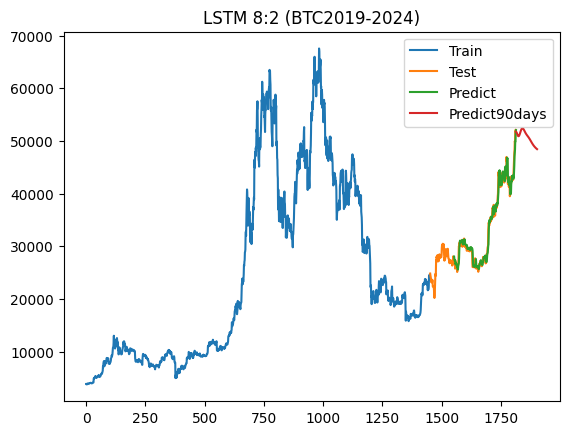

In [20]:
plt.title('LSTM 8:2 (BTC2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect90days_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect90days_data_index,scaler.inverse_transform(lst_output))  # Vẽ dự đoán cho 90 ngày
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()
